In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, GlobalAveragePooling3D, LSTM, Embedding, Activation, Flatten, AveragePooling1D, BatchNormalization, Reshape, Concatenate, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
# from keras.metrics import Recall, Precision, F1Score, Accuracy, categorical_accuracy
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
# !pip install tensorflow-addons
# import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision, F1Score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
from gensim.models import Word2Vec, fasttext
# from keras.initializers import Constant
# from keras.regularizers import  c
# from nltk.corpus import stopwords
# from tqdm import tqdm
from transformers import pipeline
import pickle

# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import keras
import os
import json
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading Data

In [ ]:
pt_nonstop = pd.read_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Data/readyToTrain/postag_without_stopwords/postag_without_stopwords.csv")
pt_nonstop["Tweet"].fillna("", inplace=True)
clearDf = pt_nonstop.copy()
max_token_sentence = max([len(text.split()) for text in clearDf["Tweet"]])
num_of_long_sentences = len([len(text.split()) for text in clearDf["Tweet"] if len(text.split())>100])
max_token_sentence
index_long_sentence = [i for i, text in enumerate(clearDf["Tweet"]) if len(text.split())>100]
clearDf.drop(index_long_sentence, axis = 0, inplace = True)

In [ ]:
embedding_matrix = np.load("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Data/readyToTrain/postag_without_stopwords/embedding_matrix.npy")

In [ ]:
# encode_text = w2v_tokenizer_fit_to_texts(formalDf["Tweet"]) # Word2Vec Tokenizer
# encode_text[0]
# loading
with open('/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Data/readyToTrain/postag_without_stopwords/ft_tokenizer.pickle', 'rb') as handle:
    ft_tokenizer = pickle.load(handle)
encode_text = ft_tokenizer.texts_to_sequences(clearDf["Tweet"])
# encode_text[0:5]

In [ ]:
# PARAM FOR EMBEDDING LAYER
max_sen_len = 100  # max sentence of a review
vocab_size = len(ft_tokenizer.index_word)+1  # total number of words
embed_dim = 300
input_dim = vocab_size
output_dim = embed_dim

# Encoding Label

In [ ]:
emotions = list(clearDf.iloc[:,1].unique())
emotions

['Fear', 'Love', 'Anger', 'Neutral', 'Sad', 'Joy']

In [ ]:
# now padding to have a amximum length of 1565
X = pad_sequences(encode_text, maxlen=max_sen_len, padding='pre', value = 0)

# y = formalDf.apply(lambda row : emotions.index(row["Label"]), axis = 1).values.astype("int32") # Label Encoding
encoder = OneHotEncoder(sparse_output = False) #Onehot encoding
y = encoder.fit_transform(clearDf[["Label"]])
lossfun = CategoricalCrossentropy()
y

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
encoder.inverse_transform(y)

array([['Fear'],
       ['Love'],
       ['Anger'],
       ...,
       ['Anger'],
       ['Joy'],
       ['Sad']], dtype=object)

In [ ]:
encode_text

# Split Dataset

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(
    X, y, random_state = 42, test_size = 0.2, stratify = y
)
X_test.shape
# X_train

(1416, 100)

# Function Pipeline

In [ ]:
slangDf = pd.read_csv("https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv")
slangDf2 = pd.read_csv("https://raw.githubusercontent.com/haryoa/indo-collex/main/dict/inforformal-formal-Indonesian-dictionary.tsv", delimiter='\t')
slangDf3 = pd.read_csv("https://raw.githubusercontent.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/master/kamus_singkatan.csv", delimiter=';', header = None)

In [ ]:
slangDict = {}

for slangIdx, row in slangDf.iterrows():
  slangDict[row["slang"]] = row["formal"]
for slangIdx, row in slangDf2.iterrows():
  slangDict[row["informal"]] = row["formal"]
for slangIdx, row in slangDf3.iterrows():
  slangDict[row[0]] = row[1]

In [ ]:
pretrained_name = "w11wo/indonesian-roberta-base-posp-tagger"

nlp = pipeline(
    "token-classification",
    model=pretrained_name,
    tokenizer=pretrained_name
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.70k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

In [ ]:
with open('/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Data/readyToTrain/postag_without_stopwords/ft_tokenizer.pickle', 'rb') as handle:
    ft_tokenizer = pickle.load(handle)

In [ ]:
def addingPOS(text) :
  pos_text = []
  pos = nlp(text)
  for i, word in enumerate(text.split()):
    pos_text.append(f"<{pos[i]['entity'][2:]}>")
    pos_text.append(word)
  return " ".join(pos_text)

In [ ]:
def cutMultChar(teks : str):
    teks = teks.split()
    newText = []
    for word in teks :
        pre = re.search(r"\b(\w)\1\1+", word)

        post = re.search(r"(\w)\1\1+\b", word)
        if pre :
            word = re.sub(r"\b(\w)\1\1+", pre.group()[0], word)
        if post :
            word = re.sub(r"(\w)\1\1+\b", post.group()[0], word)
        newText.append(word)

    return " ".join(newText)

In [ ]:
def removeStopwordsPostag(text) :
    arr = text.split()
    removable_index = []
    for i in range(len(arr)) :
        if arr[i] in stopwords_list :
            removable_index.append(i-1)
            removable_index.append(i)

    # del arr[removable_index]
    text = [word for i,word in enumerate(arr) if i not in removable_index]
    return " ".join(text)

In [ ]:
not_stopwords_list = [
    "setidaknya", "tidakkah","dia","aku","kamu","kita","mereka","tidaklah","tidak", "enggak", "enggaknya", "seseorang", "tadinya", "keterlaluan", "memberikan", "bagaimanakah",
    "apa", "kenapa", "siapa", "mengapa", "ibu", "tanpa", "tak", "mengatakan", "menyatakan", "dikatakannya","sesudahnya", "sudahlah", "menantikan", "bukannya", "bukan", "bukanlah", "kitalah",
    "ibaratnya", "sebaliknya", "kalaulah", "semisalnya", "misalnya", "misalkan", "semisalnya", "misal", "kalau", "entah", "entahlah", "mengatakan"
]

stopwords_list = set(stopwords.words('indonesian'))

# stopwords_list.remove(not_stopwords_list)

stopwords_list = set(stopwords_list).difference(not_stopwords_list)
# with open("stopwords.txt", 'w') as f :
#     f.write(str(stopwords_list))

In [ ]:
def preprocessing(s) :
    s = re.sub(r'[^\w\s]', '', s)
    s = re.sub(r'[0-9]', '', s)
    s = cutMultChar(s)
    s = re.sub(r'\b(wk)[wk]+', 'hahaha', s)
    s = re.sub(r'\b(kw)[wk]+', 'hahaha', s)
    s = re.sub(r'\b(hah)[ah]+', 'hahaha', s)
    s = re.sub(r'\b(ah)[ah]+', 'hahaha', s)
    s = re.sub(r'\b(heh)[eh]+', 'hehehe', s)
    s = re.sub(r'\b(eh)[eh]+', 'hehehe', s)
    s = addingPOS(s)
    s = removeStopwordsPostag(s)
    s = ft_tokenizer.texts_to_sequences([s])
    s = pad_sequences(s, maxlen=max_sen_len, padding='pre', value = 0)

    return np.asarray(s)

In [ ]:
input = preprocessing("Aku tidak senang saat ini")

# LSTM

In [ ]:
# from keras.src.layers.normalization.batch_normalization_v1 import BatchNormalization
def buildModelLSTM(name = None, lstm_unit = 256, dropout_lstm = 0) :
    model = Sequential() if not name else Sequential(name = name)
    # model.add(Embedding(input_dim = input_dim, output_dim = output_dim, weights = [w2v_model.wv.vectors], input_length = max_rev_len, trainable = False, mask_zero = True, embeddings_regularizer=l2(.01)))
    model.add(Embedding(input_dim = input_dim, output_dim = output_dim, weights = [embedding_matrix], input_length = max_sen_len, trainable = False))
    model.add(LSTM(256, dropout=0.3, return_sequences = False))
    model.add(Dense(6, activation='softmax'))
    return model


In [ ]:
lstm = buildModelLSTM(dropout_lstm=0.3)
lstm.load_weights("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Data/readyToTrain/postag_without_stopwords/lstm/bestweights1.h5")


In [ ]:
lstm.predict(input)

1/1 [==============================] - 0s 118ms/step


array([[0.02499781, 0.04026552, 0.28716916, 0.00590946, 0.53376013,
        0.10789793]], dtype=float32)

In [ ]:
from joblib import dump, load

encoder = load('/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Data/readyToTrain/postag_without_stopwords/encoder.joblib') # load and reuse the model

In [ ]:
encoder.inverse_transform(lstm.predict(input))

1/1 [==============================] - 0s 144ms/step


array([['Joy']], dtype=object)

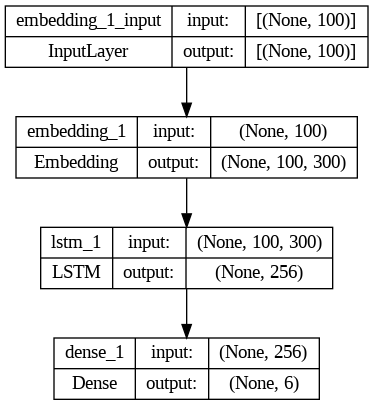

In [ ]:
import keras
keras.utils.plot_model(buildModelLSTM("LSTM Model"), to_file='LSTM_model.png', show_shapes = True)

## K-Fold Cross Validation Test

In [ ]:
for i,(train_index, test_index) in enumerate(fold10_index) :
    model = buildModelLSTM(dropout_lstm=0.3)
    checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/Skripsi/Revisi/split50_50/lstm/10-fold/bestweights{i}.h5",monitor='val_loss', verbose=0, restore_best_weights=True, mode='min', save_weights_only = True)
    model.fit(x=X_test[train_index], y = y_test[train_index], epochs = 50, validation_data = (X_test[test_index], y_test[test_index]), callbacks = [stop_early, checkpoint], verbose = False)

In [ ]:
lstm10_fold_performance = []

for i in range(10):
    model = buildModelLSTM(dropout_lstm=0.3)
    model.load_weights(f"/content/drive/MyDrive/Skripsi/Revisi/split50_50/lstm/10-fold/bestweights{i}.h5")
    model.compile(loss=lossfun, optimizer=optimizer, metrics = metrics)
    eval_metric = model.evaluate(X_test[fold10_index[i][1]],y_test[fold10_index[i][1]])
    y_pred = model.predict(X_test[fold10_index[i][1]])
    y_pred = [np.argmax(pred) for pred in y_pred]
    y_true = [np.argmax(true) for true in y_test[fold10_index[i][1]]]
    fold_metrics = {}
    fold_metrics["num_fold"] = i
    for j, metric_name in enumerate(model.metrics_names) :
        fold_metrics[metric_name] = eval_metric[j]
    macro_precision = precision_score(y_true, y_pred, average='macro')
    part_precision = precision_score(y_true, y_pred, average = None)
    macro_recall = recall_score(y_true, y_pred, average = 'macro')
    part_recall = recall_score(y_true, y_pred, average = None)
    macro_f1 = f1_score(y_true, y_pred, average = 'macro')
    part_f1 = f1_score(y_true, y_pred, average = None)
    fold_metrics["macro_precision"] = macro_precision
    fold_metrics["macro_recall"] = macro_recall
    fold_metrics["macro_f1"] = macro_f1
    fold_metrics["part_precision"] = part_precision.tolist()
    fold_metrics["part_recall"] = part_recall.tolist()
    fold_metrics["part_f1"] = part_f1.tolist()



    lstm10_fold_performance.append(fold_metrics)

12/12 [==============================] - 0s 4ms/step


#CNN-LSTM

In [ ]:
def buildModelCNN3LSTMEksperimen(name = None, num_of_kernel = 64, kernel_size = [4,6,8], lstm_unit = 256, pool_size = 2, dropout_lstm = 0, dropout_rate = 0.5) :
    input_layer = Input(shape = (max_sen_len,))
    embedding_layer = Embedding(input_dim = input_dim, output_dim = output_dim, weights = [embedding_matrix], input_length = max_sen_len, trainable = False)(input_layer)
    def add_conv_layer(filter_size):
        return Conv1D(filters=num_of_kernel, kernel_size=filter_size, activation='relu', padding='same')(embedding_layer)

    list_conv_layer = []
    for ks in kernel_size :
        list_conv_layer.append(add_conv_layer(ks))

    # Concatenate the outputs of the three Conv1D layers
    concatenate = Concatenate(axis=-1)(list_conv_layer)
    dropout = Dropout(dropout_rate)(concatenate)
    pooling_layer = MaxPool1D()(dropout)
    dropout = Dropout(dropout_rate)(pooling_layer)
    # model.add(BatchNormalization())
    # model.add(Dropout(dropout_rate))
    lstm = LSTM(lstm_unit, dropout = dropout_lstm, return_sequences = False)(dropout)
    dropout = Dropout(dropout_rate)(lstm)
    output_layer = Dense(6, activation='softmax')(dropout)
    # output_layer = Dense(6, activation='softmax')(lstm)
    model = Model(inputs = input_layer, outputs = output_layer)
    # optimizer = keras.optimizers.legacy.Adam(learning_rate = 0.0001)
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
    return model

In [ ]:
c3lstm = buildModelCNN3LSTMEksperimen()
c3lstm.load_weights("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/HasilKFold/c3lstm_par3/bestModel12.h5")


In [ ]:
encoder.inverse_transform(c3lstm.predict(input))

1/1 [==============================] - 0s 80ms/step


array([['Neutral']], dtype=object)

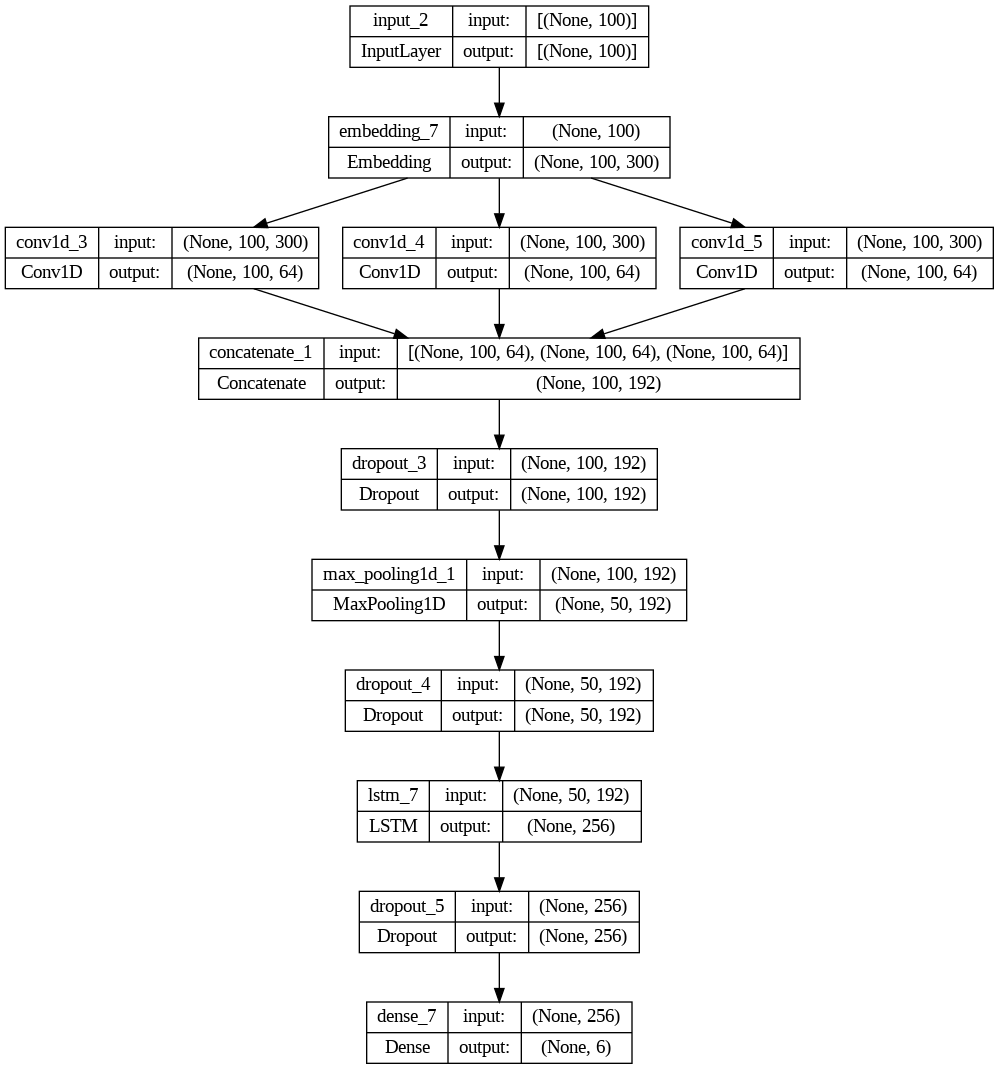

In [ ]:
import keras
keras.utils.plot_model(buildModelCNN3LSTMEksperimen("CNN-LSTM Model"), to_file='CNN_LSTM_model.png', show_shapes = True)